# MDC from step by step

(480, 640, 3)


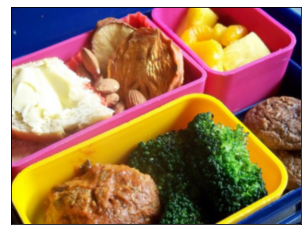

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

def imshow(img):
    try:
        if img.shape[2]==3:
            pic = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            plt.imshow(pic, interpolation = 'bicubic')
    except:
        plt.imshow(img)
    plt.xticks([]), plt.yticks([]) # 隐藏 X 和 Y 轴的刻度值
def matrix_imshow(imgs):
    ''''
    imgs必须是一个2d矩阵, 矩阵每个元素是一张图
    '''
    for i in range(imgs.shape[0]):
        for j in range(imgs.shape[1]):
            plt.subplot(imgs.shape[0],imgs.shape[1],i+1)
            imshow(imgs[i,j])
def list_imshow(imgs):
    '''
    imgs是一个list
    '''
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs),i+1)
        imshow(imgs[i])

img = cv.imread('test_images/1.jpg')
imshow(img)
print(img.shape)


In [3]:
## 超参
ALPHA = 0.8
BETA = 0.3
THETA = 0.2

## Minimum Directional Contrast (MDC)

In [4]:
# 使用积分图做加速，但算的还是很慢，（480，640）的图片需要算1min
sum,sqsum = cv.integral2(img)
area_sum = lambda sum,x1,x2,y1,y2 : (sum[y2,x2,:] - sum[y1,x2,:] - sum[y2,x1,:] + sum[y1,x1,:])

h = img.shape[0]
w = img.shape[1]
S = np.zeros((h,w))
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        TL = np.sum(area_sum(sqsum,0,x+1,0,y+1)) - 2*np.sum(area_sum(sum,0,x+1,0,y+1)*img[y,x,:]) + (x+1)*(y+1)*np.sum(np.power(img[y,x,:],2,dtype=np.uint32))# 标明类型，不然会因为都进来的图片是uint8而取完指数后溢出
        TR = np.sum(area_sum(sqsum,x,-1,0,y+1)) - 2*np.sum(area_sum(sum,x,-1,0,y+1)*img[y,x,:]) + (w-x)*(y+1)*np.sum(np.power(img[y,x,:],2,dtype=np.uint32))
        BL = np.sum(area_sum(sqsum,0,x+1,y,-1)) - 2*np.sum(area_sum(sum,0,x+1,y,-1)*img[y,x,:]) + (x+1)*(h-y)*np.sum(np.power(img[y,x,:],2,dtype=np.uint32))
        BR = np.sum(area_sum(sqsum,x,-1,y,-1)) - 2*np.sum(area_sum(sum,x,-1,y,-1)*img[y,x,:]) + (w-x)*(h-y)*np.sum(np.power(img[y,x,:],2,dtype=np.uint32))
        S[y,x] = np.sqrt(np.min([TL,TR,BL,BR]))

(480, 640)


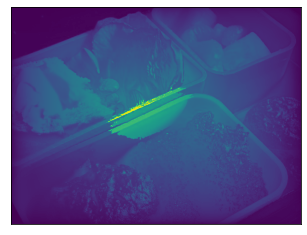

In [5]:
print(S.shape)
imshow(S)# 原始显著性图

## Saliency Smoothing

未作将特征空间从256^3降到L^3的操作, 后面那个也不太会做

## Saliency Enhancement

未实现形态学滤波

In [6]:
S = S/np.max(S)*255
gray  = S.astype(np.uint8)
# OTSU计算阈值T
T,_ = cv.threshold(gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)# OTSU需要输入必须是uint8，所以前面做了一下归一化
# 得到用于进行分水岭算法的marker矩阵，1为前景，2为背景，0为其他
marker = np.zeros((img.shape[0],img.shape[1]),dtype=np.int32)#注意元素的类型
marker = np.where(gray>(1+THETA)*T,1,marker)
marker = np.where(gray<(1-THETA)*T,2,marker)

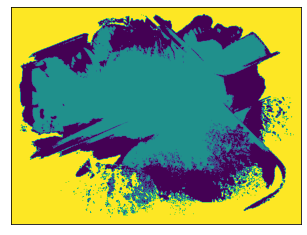

In [7]:
imshow(marker)

In [8]:
# 在原图上运行分水岭算法
marker = cv.watershed(img,marker)

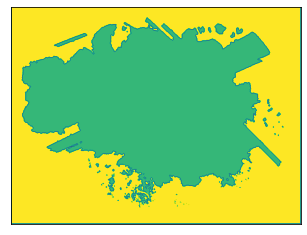

In [9]:
imshow(marker)

In [10]:
S_enhance = np.where(marker==1,1-ALPHA*(1-S),S)
S_enhance = np.where(marker==2,BETA*S,S)

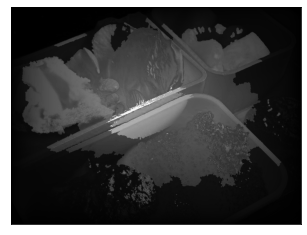

In [11]:
imshow(S_enhance)
plt.set_cmap('gray')